<a 
href="https://colab.research.google.com/github/adilo231/Python-for-machine-learning/blob/main/Chap -5- Demarche De datascientist/2- Pretraitement de donnees (Corrige).ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:

data = pd.read_excel('Datasets/dataset.xlsx')
df = data.copy()

# PRE-PROCESSING

- Création du Train set / Test set
- Élimination des NaN : dropna(), imputation
- Encodage
- Suppression des valeurs aberrantes
- Sélection de caractéristique (Feature Selection)
- Ingénierie des caractéristique (Feature Engineering)
- Mise à l'échelle des caractéristique (Feature Scaling)

## Création des sous-ensembles 

In [27]:
missing_rate = df.isna().sum()/df.shape[0]


In [28]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [29]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [30]:
df = df[key_columns + blood_columns + viral_columns]


## Data split - Nettoyage - Encodage

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [33]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [34]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [35]:
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [36]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [37]:
def imputation(df):
    df = df.dropna(axis=0)
    return  df

In [38]:
def preprocessing(df):
    df = encodage(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    print(y.value_counts())
    
    return X, y

In [39]:
X_train, y_train = preprocessing(trainset)

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [40]:
X_test, y_test = preprocessing(testset)

0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Modellisation

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

In [42]:
model_1 = RandomForestClassifier(random_state=0)

In [53]:
model_2 = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10),
                      RandomForestClassifier(random_state=0))

## Procédure d'évaluation

In [44]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [45]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

[[54  0]
 [11  1]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        54
           1       1.00      0.08      0.15        12

    accuracy                           0.83        66
   macro avg       0.92      0.54      0.53        66
weighted avg       0.86      0.83      0.77        66



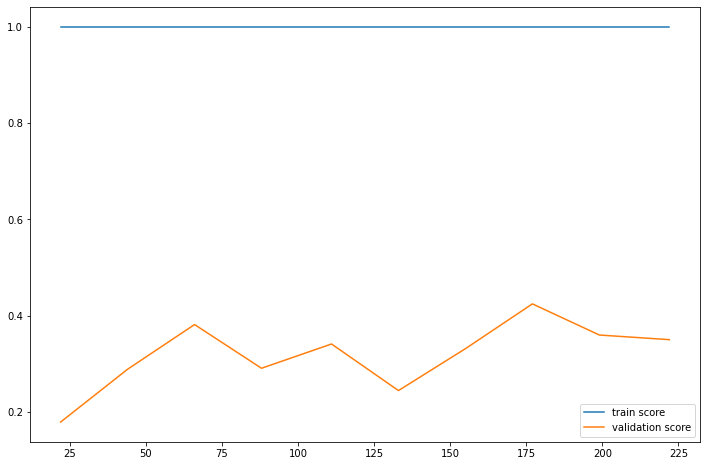

In [46]:
evaluation(model_1)

<AxesSubplot:>

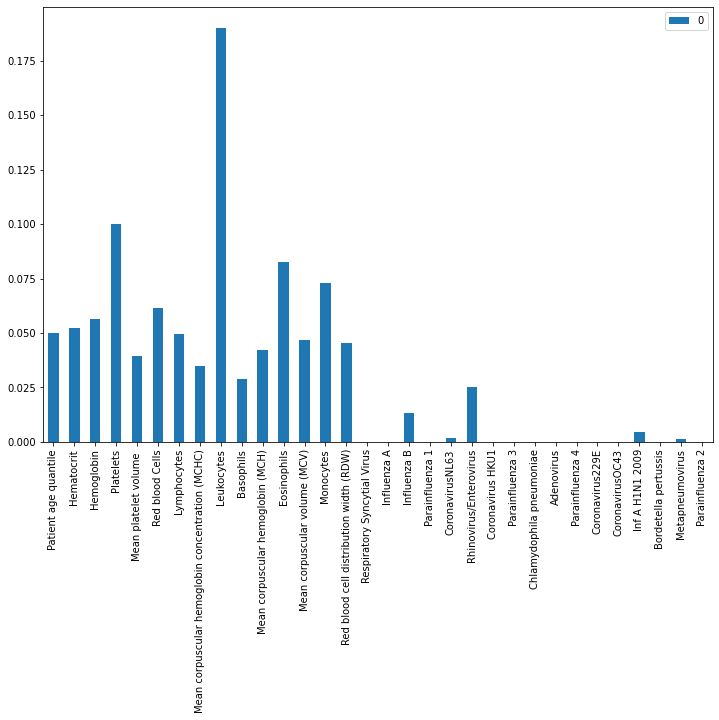

In [47]:
pd.DataFrame(model_1.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  0  19  24  30  32  48  51  56  57  58  62  64  82  87  93  95 112 117
 123 125 141 146 152 154 169 174 180 182 196 201 207 209 222 227 233 235
 247 252 258 260 271 276 282 284 294 299 305 307 316 321 327 329 337 342
 348 350 357 362 368 370 376 381 387 389 394 399 405 407 409 410 411 412
 414 415 416 418 419 420 421 422 423 424 426 427 428 429 430 431 432 433
 435 436 438 439 440 442 443 445 446 447 448 449 450 451 453 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 471 472 474 475 476 477
 478 479 480 481 482 484 485 486 488 489 491 492 493 494 496 497 498 499
 500 501 502 503 504 505 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 526 527 528 529 530 531 532 534 535 536 537 538
 539 541 542 543 544 545 547 548 549 550 552 553 554 555 556 557 559 560] are constant.
  warnings.warn("Features %s are constant." % const

[[51  3]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        54
           1       0.50      0.25      0.33        12

    accuracy                           0.82        66
   macro avg       0.68      0.60      0.61        66
weighted avg       0.79      0.82      0.79        66



/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  0  16  17  19  22  23  24  25  26  27  28  29  30  31  32  48  49  51
  54  55  56  57  58  59  60  61  62  63  64  79  80  82  85  86  87  88
  89  90  91  92  93  94  95 109 110 112 115 116 117 118 119 120 121 122
 123 124 125 138 139 141 144 145 146 147 148 149 150 151 152 153 154 166
 167 169 172 173 174 175 176 177 178 179 180 181 182 193 194 196 199 200
 201 202 203 204 205 206 207 208 209 219 220 222 225 226 227 228 229 230
 231 232 233 234 235 244 245 247 250 251 252 253 254 255 256 257 258 259
 260 268 269 271 274 275 276 277 278 279 280 281 282 283 284 291 292 294
 297 298 299 300 301 302 303 304 305 306 307 313 314 316 319 320 321 322
 323 324 325 326 327 328 329 334 335 337 340 341 342 343 344 345 346 347
 348 349 350 354 355 357 360 361 362 363 364 365 366 367 368 369 370 373
 374 376 379 380 381 382 383 384 385 386 387 388 389 391 392 394 3

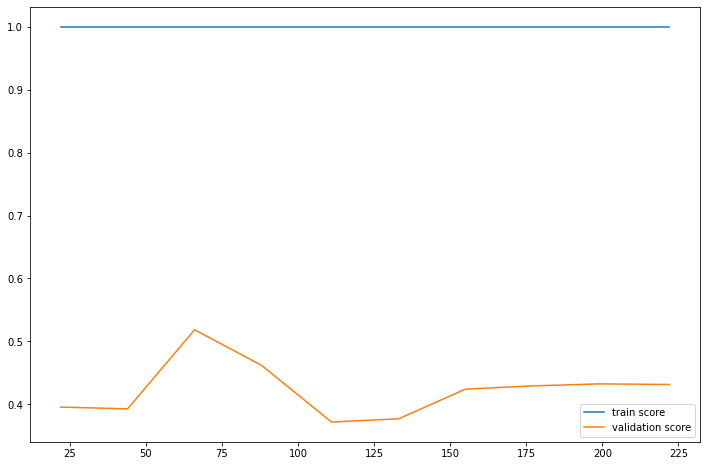

In [55]:
evaluation(model_2)